This script contains the DGMR model, which uses KNMI's radar data of the previous 20 minutes as input and gives precipitation forecasts for the next 7,5 hour as output (in numpy arrays for every 5 minute). This script also contains sections that shows how the DGMR output is visualized and how the radar data is downloaded from KNMI's api.

Made by Florian Dekker and Kevin Luo

## Install the required packages

This section is taken from the DGMR python script of Joep Bosdijk.

In [ ]:
!pip -q install tensorflow numpy matplotlib tensorflow_hub cartopy pysteps wradlib==1.18.0 rioxarray


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.9/568.9 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.2/306.2 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.0 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y shapely
!pip install shapely --no-binary shapely

Found existing installation: shapely 2.0.4
Uninstalling shapely-2.0.4:
  Successfully uninstalled shapely-2.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.9/280.9 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shapely: filename=shapely-2.0.4-cp310-cp310-linux_x86_64.whl size=1025348 sha256=e4a9986f03b41eb1635a11ab13cdbe18be80c892220425c8aebb0167921336dc
  Stored in directory: /root/.cache/pip/wheels/85/0b/57/c3140e472fde452aa215492a886f7859aeba06f6b47ae35ee9
Successfully built shapely


## Mount to Google Drive

This section is needed to use data from the personal Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import the packages

This part is taken from the DGMR python script of Joep Bosdijk.

In [ ]:
from datetime import date,datetime, timedelta
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import shapely.geometry as sgeom
import tensorflow as tf
import tensorflow_hub
from google.colab import auth
import itertools
import pysteps
from pysteps.verification.interface import get_method
from pysteps.verification import spatialscores
from pysteps import io, nowcasts, rcparams
from pysteps.utils import conversion, transformation, dimension
from pysteps.visualization.precipfields import plot_precip_field
import pyproj

import random
import shutil
import requests
import wradlib

import numpy as np
from scipy.spatial.distance import cdist
from numba import jit, prange

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



## Load the DGMR model and other required functions

This section is taken from the DGMR python script of Joep Bosdijk.

In [ ]:
#Loading the model and all the functions needed to run it
TFHUB_BASE_PATH = "gs://dm-nowcasting-example-data/tfhub_snapshots"
def load_module(input_height, input_width):
  """Load a TF-Hub snapshot of the 'Generative Method' model."""
  hub_module = tensorflow_hub.load(
      os.path.join(TFHUB_BASE_PATH, f"{input_height}x{input_width}"))
  # Note this has loaded a legacy TF1 model for running under TF2 eager mode.
  # This means we need to access the module via the "signatures" attribute. See
  # https://github.com/tensorflow/hub/blob/master/docs/migration_tf2.md#using-lower-level-apis
  # for more information.
  return hub_module.signatures['default']

module = load_module(1536, 1280)

def predict(module, input_frames, num_samples=1,
            include_input_frames_in_result=False):
  """Make predictions from a TF-Hub snapshot of the 'Generative Method' model.
  Args:
    module: One of the raw TF-Hub modules returned by load_module above.
    input_frames: Shape (T_in,H,W,C), where T_in = 4. Input frames to condition
      the predictions on.
    num_samples: The number of different samples to draw.
    include_input_frames_in_result: If True, will return a total of 22 frames
      along the time axis, the 4 input frames followed by 18 predicted frames.
      Otherwise will only return the 18 predicted frames.

  Returns:
    A tensor of shape (num_samples,T_out,H,W,C), where T_out is either 18 or 22
    as described above.
  """
  input_frames = tf.math.maximum(input_frames, 0.)
  # Add a batch dimension and tile along it to create a copy of the input for
  # each sample:
  input_frames = tf.expand_dims(input_frames, 0)
  input_frames = tf.tile(input_frames, multiples=[num_samples, 1, 1, 1, 1])
  print(tf.shape(input_frames))
  # Sample the latent vector z for each sample:
  _, input_signature = module.structured_input_signature

  z_size = input_signature['z'].shape[1]
  z_samples = tf.random.normal(shape=(num_samples, z_size))

  inputs = {
      "z": z_samples,
      "labels$onehot" : tf.ones(shape=(num_samples, 1)),
      "labels$cond_frames" : input_frames
  }
  samples = module(**inputs)['default']
  print('model_ran')
  if not include_input_frames_in_result:
    # The module returns the input frames alongside its sampled predictions, we
    # slice out just the predictions:
    samples = samples[:, NUM_INPUT_FRAMES:, ...]

  # Take positive values of rainfall only.
  samples = tf.math.maximum(samples, 0.)
  return samples

NUM_INPUT_FRAMES = 4
NUM_TARGET_FRAMES = 18


def extract_input_and_target_frames(radar_frames):
  """Extract input and target frames from a dataset row's radar_frames."""
  # We align our targets to the end of the window, and inputs precede targets.
  input_frames = radar_frames[-NUM_TARGET_FRAMES-NUM_INPUT_FRAMES : -NUM_TARGET_FRAMES]
  target_frames = radar_frames[-NUM_TARGET_FRAMES : ]
  return input_frames, target_frames


def horizontally_concatenate_batch(samples):
  n, t, h, w, c = samples.shape
  # N,T,H,W,C => T,H,N,W,C => T,H,N*W,C
  return tf.reshape(tf.transpose(samples, [1, 2, 0, 3, 4]), [t, h, n*w, c])

def predictRainfall(eventSelected, name):
  num_samples = 1
  input_frames, target_frames  = extract_input_and_target_frames(eventSelected)
  print(tf.shape(input_frames))
  print(tf.shape(target_frames))
  samples = predict(module, input_frames, num_samples=num_samples, include_input_frames_in_result=False)

  return(samples, target_frames)

## Specify the date

This section specifies the timestamp for which the precipitation forecast is generated.

In [ ]:
# Specify start and end time
start_time_str = "2024-06-16 11:00:00"
end_time_str = "2024-06-16 18:30:00"

In [ ]:
# Name for the folder where the DGMR output will be saved in
folder_name = "DGMR_202406160600"

In [ ]:
# Create the output folder
os.makedirs('/content/drive/MyDrive/Colab Notebooks/' + folder_name)

## Defining the input data

This section creates a list of the previous 20 minutes, which will be used as input for the DGMR model. This part is not taken from Joep Bosdijk and is created specifically for this thesis project.

In [ ]:
from datetime import datetime, timedelta

start = datetime.strptime(start_time_str, "%Y-%m-%d %H:%M:%S")

file_list = []

# Generate the 7 timestamps prior to start_time (including start_time itself)
current_time = start
for _ in range(7):
    file_list.append(current_time.strftime('RAD_NL25_PCP_NA_%Y%m%d%H%M.h5'))
    current_time -= timedelta(minutes=5)

print(file_list)

['RAD_NL25_PCP_NA_202406161100.h5', 'RAD_NL25_PCP_NA_202406161055.h5', 'RAD_NL25_PCP_NA_202406161050.h5', 'RAD_NL25_PCP_NA_202406161045.h5', 'RAD_NL25_PCP_NA_202406161040.h5']


In [ ]:
# The directory to the folder on Google Drive, which contains the complete dataset of radar data from KNMI
direc = '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete'

## Convert radar data

This part converts radar data (in dBZ) to precipitation rates (in mm/h).
This part is mainly taken from the DGMR python script of Joep Bosdijk, except for the adjusted directory.

In [ ]:
# convert knmi_files to mm/h
def boolstr_to_floatstr(v):
    if v == True:
        return 0
    else:
        return 1

fns_file = []
for n in range(len(file_list)):
  fns_file.append(direc+ '/'+ file_list[n])

fns_datetime = []

fns = []
fns.append(fns_file)
fns.append(start.strftime("%Y%m%d%H%M"))
print(fns)

path_fmt = 'KNMI complete/'

importer_name = 'knmi_hdf5'
importer_kwargs = {'accutime': 5, 'qty': 'DBZH', 'pixelsize': 1000.0}

importer = io.get_method(importer_name, "importer")
R, _, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

R[np.isnan(R)] = 0

#Apply Gabella filter
clutter = []
for i,j in enumerate(R):
    clutter.append(wradlib.clutter.filter_gabella(img=R[i,:,:], wsize=5))

# # create binary matrix fro true/false matrix
clutter = np.vectorize(boolstr_to_floatstr)(clutter).astype(float)

# #multiply binary matrix with rain rate matrix to set the clutter pixels to 0.
R = np.multiply(R,clutter)

#Convert to rain rate
R, metadata = conversion.to_rainrate(R, metadata)


[['/content/drive/MyDrive/Colab Notebooks/KNMI_Complete/RAD_NL25_PCP_NA_202406161100.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete/RAD_NL25_PCP_NA_202406161055.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete/RAD_NL25_PCP_NA_202406161050.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete/RAD_NL25_PCP_NA_202406161045.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete/RAD_NL25_PCP_NA_202406161040.h5'], '202406161100']


## Start DGMR model

This section initiate the DGMR model using the input data with the precipitation rates from previous sections. This part is adapted from the DGMR python script Joep Bosdijk and is adjusted for this thesis project. In the original code, the DGMR only gives forecasts for the next 90 minutes (18 arrays), the adjustment ensures that the DGMR gives forecasts for 6 additional hours. This is needed for the blending process.

In [ ]:
# Adjusted from Joep Bosdijk

input_DGMR = np.tile(R[-4][np.newaxis, :], (4, 1, 1))
print(np.shape(input_DGMR))

paddings = tf.constant([[0, 0], [385, 386], [290, 290]])
input_DGMR = tf.pad(input_DGMR, paddings, "CONSTANT")
input_DGMR = np.float32(input_DGMR)
input_DGMR = np.reshape(input_DGMR, (4, 1536, 1280, 1))
print(np.shape(input_DGMR))

# First prediction
prediction = predict(module, input_DGMR, num_samples=1, include_input_frames_in_result=False)[0]
prediction = np.reshape(prediction, (18, 1536, 1280, 1))

# Initialize the extended predictions array
extended_predictions = prediction

# Loop to extend predictions for additional 6 hours (72 steps, assuming each step is 5 minutes)
steps = 72 // 18  # Number of iterations needed, as each prediction step gives 18 frames

for _ in range(steps):
    # Use the last 4 frames from the previous prediction as input for the next prediction
    input_frames = extended_predictions[-4:]
    prediction = predict(module, input_frames, num_samples=1, include_input_frames_in_result=False)[0]
    prediction = np.reshape(prediction, (18, 1536, 1280, 1))
    extended_predictions = np.concatenate((extended_predictions, prediction))

# Final shape of the extended predictions
print(np.shape(extended_predictions))

# From here, it is taken from Joep Bosdijk

#depad the output of DGMR and run the cumulative and probability conversion
DGMR_depad = extended_predictions[:, 385:1150, 290:990, :]
print(DGMR_depad.shape)

DGMR_det = np.reshape(DGMR_depad,(len(extended_predictions),765,700))
print(DGMR_det.shape)

DGMR_det_cum = []
#calclate the cumulative precipitation
for i in range(len(DGMR_det) - 12):
    DGMR_det_cum.append(DGMR_det[i:i+12, :,:].sum(axis = 0))

DGMR_det_cum_np = np.asarray(DGMR_det_cum)

@jit(nopython=True, parallel=True)
def count_neighboring_values_numba(arr,padded_arr, threshold, space_radius, time_radius, max_cells):

    counts = np.zeros(arr.shape, dtype=np.float64)
    radius_squared = space_radius**2

    for i in prange(time_radius, arr.shape[0] + time_radius):
        for j in prange(space_radius, arr.shape[1] + space_radius):
            for k in prange(space_radius, arr.shape[2] + space_radius):
                count = 0

                for t in range(i - time_radius, i + time_radius + 1):
                    for x in range(j - space_radius, j + space_radius + 1):
                        for y in range(k - space_radius, k + space_radius + 1):
                            if (x - j)*2 + (y - k)*2 <= radius_squared:
                                if padded_arr[t, x, y] > threshold:
                                    count += 1

                counts[i - time_radius, j - space_radius, k - space_radius] = count / max_cells


    return counts

threshold = 25
space_radius = 6
time_radius = 1


x, y,z = np.mgrid[-time_radius:time_radius +1, -space_radius:space_radius+1, -space_radius:space_radius+1]
distance_mask = np.sqrt(y*2 + z*2) <= space_radius

max_cells = np.sum(distance_mask == True)

DGMR_det_cum_pad = np.pad(DGMR_det_cum_np, ((time_radius, time_radius),
                             (space_radius, space_radius),
                             (space_radius, space_radius)), mode='constant')


DGMR_prob_cum_numba = count_neighboring_values_numba(DGMR_det_cum_np,DGMR_det_cum_pad, threshold,space_radius,time_radius, max_cells)

from PIL import Image

DGMR_depad = extended_predictions[:, 385:1150, 290:990, :]
DGMR_output = np.reshape(DGMR_depad, (len(DGMR_depad),765,700))

DGMR_output = np.reshape(DGMR_output,(len(DGMR_output),765,700))


(4, 765, 700)
(4, 1536, 1280, 1)
tf.Tensor([   1    4 1536 1280    1], shape=(5,), dtype=int32)
model_ran
tf.Tensor([   1    4 1536 1280    1], shape=(5,), dtype=int32)
model_ran
tf.Tensor([   1    4 1536 1280    1], shape=(5,), dtype=int32)
model_ran
tf.Tensor([   1    4 1536 1280    1], shape=(5,), dtype=int32)
model_ran
tf.Tensor([   1    4 1536 1280    1], shape=(5,), dtype=int32)
model_ran
(90, 1536, 1280, 1)
(90, 765, 700, 1)
(90, 765, 700)


## Save the DGMR output

This section saves the arrays with the DGMR output into the created folder. This part is made for this thesis project.

In [ ]:
start_timestamp = datetime.strptime(start_time_str, "%Y-%m-%d %H:%M:%S") + timedelta(minutes=5)

# Loop to save each array with the incremented timestamp
for i in range(90):
    # Calculate the new timestamp
    timestamp = start_timestamp + timedelta(minutes=5 * i)
    # Format the timestamp as a string
    filename = timestamp.strftime("DGMR_%Y%m%d%H%M.npy")
    # Save the array
    np.save('/content/drive/MyDrive/Colab Notebooks/' + folder_name + '/' + filename, DGMR_output[i])
    print(f"Saved {filename}")

Saved DGMR_202406161105.npy
Saved DGMR_202406161110.npy
Saved DGMR_202406161115.npy
Saved DGMR_202406161120.npy
Saved DGMR_202406161125.npy
Saved DGMR_202406161130.npy
Saved DGMR_202406161135.npy
Saved DGMR_202406161140.npy
Saved DGMR_202406161145.npy
Saved DGMR_202406161150.npy
Saved DGMR_202406161155.npy
Saved DGMR_202406161200.npy
Saved DGMR_202406161205.npy
Saved DGMR_202406161210.npy
Saved DGMR_202406161215.npy
Saved DGMR_202406161220.npy
Saved DGMR_202406161225.npy
Saved DGMR_202406161230.npy
Saved DGMR_202406161235.npy
Saved DGMR_202406161240.npy
Saved DGMR_202406161245.npy
Saved DGMR_202406161250.npy
Saved DGMR_202406161255.npy
Saved DGMR_202406161300.npy
Saved DGMR_202406161305.npy
Saved DGMR_202406161310.npy
Saved DGMR_202406161315.npy
Saved DGMR_202406161320.npy
Saved DGMR_202406161325.npy
Saved DGMR_202406161330.npy
Saved DGMR_202406161335.npy
Saved DGMR_202406161340.npy
Saved DGMR_202406161345.npy
Saved DGMR_202406161350.npy
Saved DGMR_202406161355.npy
Saved DGMR_202406161

## Create visualization

This part plot the DGMR output on a map over the Netherlands and is used to check if there is any anomalies in the DGMR output. This part is also adapted from Joep Bosdijk.

In [ ]:
# Create basic information needed to plot the data on a map
minlon = 0.99
maxlon = 9.87
minlat = 50.18
maxlat = 54.69
metadata =  {'projection': '+proj=stere +lat_0=90 +lon_0=0.0 +lat_ts=60.0 +a=6378137 +b=6356752 +x_0=0 +y_0=0',
        # 'x1': 0.0,
        # 'y1': -4414999.289971201,
        # 'x2': 70001.8290865897,
        # 'y2': -3649995.4110607,
        "x1": 110000.,
        "y1": -4304999.2899712,
        "x2": 700001.,
        "y2": -3759995.2899712,
        'xpixelsize': 2500.0,
        'ypixelsize': 2500.0,
        'cartesian_unit': 'm',
        'yorigin': 'upper',
        'institution': 'KNMI - Royal Netherlands Meteorological Institute',
        'accutime': 5,
        'unit': 'mm/h',
        'transform': None,
        'zerovalue': 0.0,
        'threshold': 0.0003918377307968165,
        'zr_a': 200.0,
        'zr_b': 1.6}

images = []
P = pyproj.Proj(metadata['projection'])
xmin,ymin = P(minlon,minlat)
xmax,ymax = P(maxlon,maxlat)

<GeoAxes: title={'center': 'trial'}>

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloadin

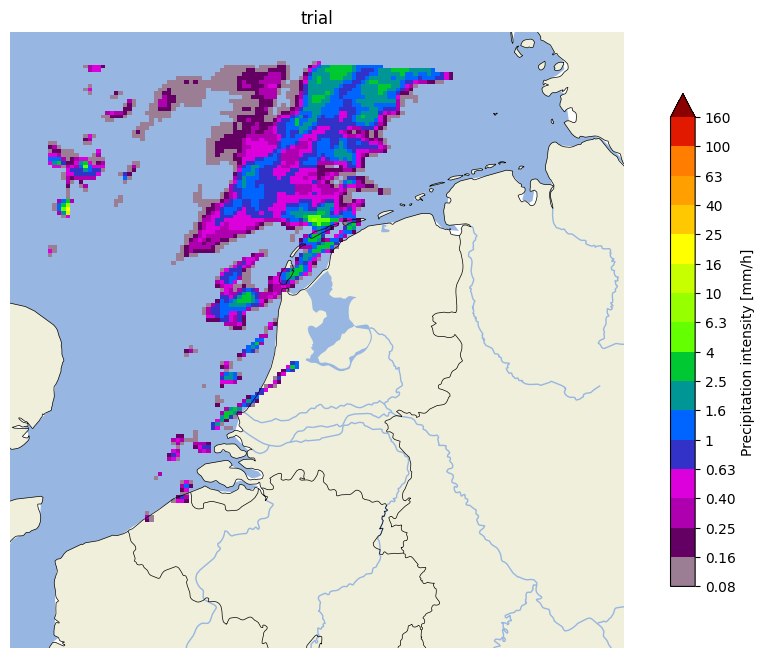

In [ ]:
# Load the array with DGMR output
first_array = np.load("/content/drive/MyDrive/Colab Notebooks/NWP/test2.npy")

fig = plt.figure(figsize=(12,8))

# Plot the precipitation rates with pysteps
plot_precip_field(first_array,
                  geodata = metadata,
                  title='trial',
                  map_kwargs={'plt_map':'cartopy',
                              'scale':'10m'},
                  bbox=(xmin,ymin,xmax,ymax)
                  )

## Download radar data from KNMI's API

This section does not belong to the DGMR but was needed in some cases to download radar data for specific timeperiods. This is done with KNMI's api, using a bulk key. This part is adapted from Joep Bosdijk but adjusted so that specific start and end times can be defined.

In [ ]:
# Download data from specific timestamps
import requests
import shutil
from datetime import datetime, timedelta

def daterange(start_time, end_time, interval_minutes=5):
    current_time = start_time
    while current_time <= end_time:
        yield current_time
        current_time += timedelta(minutes=interval_minutes)

# This part is added for this thesis project
# Specify desired period here
start_date = datetime.strptime('2024-06-04 00:00:00', "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime('2024-06-05 00:00:00', "%Y-%m-%d %H:%M:%S")

file_list = []

# For the normal radar data
for single_date in daterange(start_date, end_date):
    file_list.append(single_date.strftime('RAD_NL25_PCP_NA_%Y%m%d%H%M.h5'))

url = 'https://api.dataplatform.knmi.nl/open-data/v1/datasets/radar_reflectivity_composites/versions/2.0/files'
api_key = 'eyJvcmciOiI1ZTU1NGUxOTI3NGE5NjAwMDEyYTNlYjEiLCJpZCI6ImE3NmYwMDNkY2EwMzQ5NjdiNzg2MTZlYWI1ZjBkN2Y1IiwiaCI6Im11cm11cjEyOCJ9'

# Directory of where the downloaded data will be saved in
direc = '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete/'

# From here, it is taken from Joep Bosdijk
for fn in file_list:
    try:
        get_file_response = requests.get(url+'/'+fn+'/url', headers={'Authorization': api_key})

        download_url = get_file_response.json().get("temporaryDownloadUrl")

        dataset_file = requests.get(download_url, stream=True)

        if dataset_file.status_code == 200:
            with open(direc + fn, 'wb') as f:
                dataset_file.raw.decode_content = True
                print(f"Downloading {fn}...")
                shutil.copyfileobj(dataset_file.raw, f)
        else:
            print(f"Failed to download {fn}: HTTP {dataset_file.status_code}")
    except Exception as e:
        print(f'Was not able to download this file: {fn}')
        print(f'Error: {e}')


KeyboardInterrupt: 